In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from PIL import Image
import keras
import keras_cv
import os

In [2]:
batch_size = 24
img_size = (380, 380, 3)
momentum = 0.9
epochs_freeze = 10
epochs_finetune = 64
learning_rate_freeze = 0.03
learning_rate_finetune = 0.0001
weight_decay =  0.00003

In [3]:
train_dir = 'train'
test_dir = 'test'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  class_names = ['angry','disgust','fear','happy','neutral','sad','surprise'],
  seed = 123,
  image_size = (48, 48),
  color_mode = 'grayscale',
  batch_size = batch_size)
# load training dataset in TensorFlow in batches, using a seed; the dataset is shuffled by default before batching

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  class_names = ['angry','disgust','fear','happy','neutral','sad','surprise'],
  seed = 123,
  color_mode = 'grayscale',
  image_size = (48, 48),
  batch_size = batch_size)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


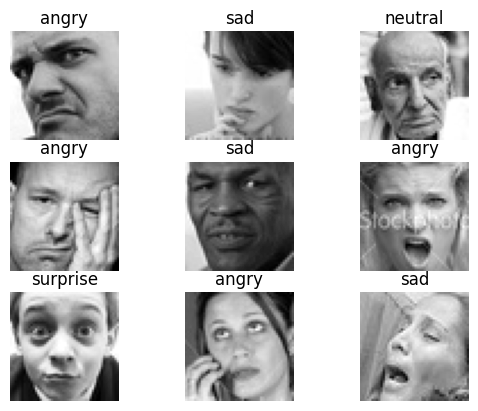

In [18]:
for images,labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, 1 + i)  # divide into 9 subplots and set current image at corresponding subplot
        plt.imshow(images[i], cmap='gray')  # show current image after converting properly (doesn't show otherwise)
        plt.title(train_ds.class_names[labels[i].numpy()])  # show class as title; get numerical label first, then convert to original class
        plt.axis("off")

In [ ]:
# let's prepare the image augmentations, which will be random translations and colour jitters, following the paper values

translation = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)

jitter_set = [
    layers.RandomBrightness(factor=0.1),
    layers.RandomContrast(factor=0.1),
    keras_cv.layers.RandomSaturation(factor=(0.45,0.55)),
    keras_cv.layers.RandomHue(factor=0.2, value_range=[0,255])
]

def colour_jitter(image):
    for layer in np.random.choice(range(4),4,replace=False):
        image = jitter_set[layer](image)
    return image

def img_augmentation(image):
    image = translation(image)
    image = colour_jitter(image)
    return image

In [ ]:
for images,labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, 1 + i)
        plt.imshow(np.uint8(img_augmentation(images[i])))
        plt.title(train_ds.class_names[labels[i].numpy()])
        plt.axis("off")
# test the augmentations on some training images

In [ ]:
def preprocess(image, label):
    img = img_augmentation(image)
    return img, label
# define function for applying augmentation to dataset

In [ ]:
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
# map augmentation function to training dataset and prefetch batches for (possibly) improved performance

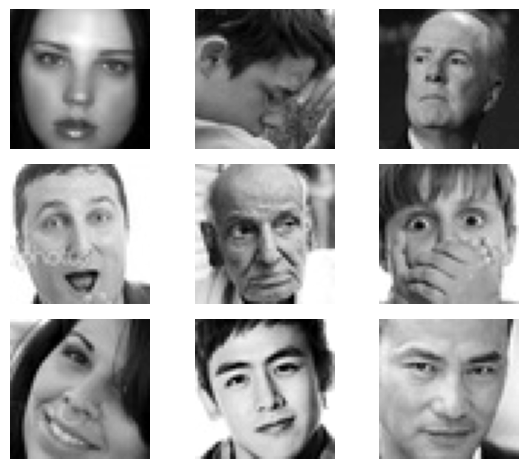

In [17]:
for images,labels in train_ds.take(1):
    for index in range(9):
        plt.subplot(3,3, 1 + index)
        plt.imshow(images[index], cmap='gray')
        plt.axis("off")
        plt.tight_layout()
# inspect some of the resulting augmented training images

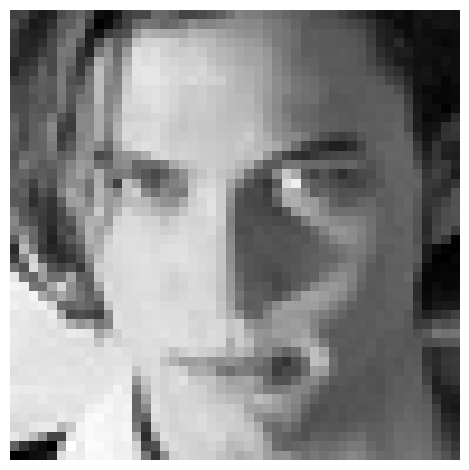

In [23]:
train_ds_unbatched = train_ds.unbatch()
for image,label in train_ds_unbatched.take(1):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()

In [25]:
for image,label in train_ds_unbatched.take(1):
    print(image,label)

tf.Tensor(
[[[ 46.]
  [ 40.]
  [ 56.]
  ...
  [162.]
  [161.]
  [161.]]

 [[ 56.]
  [114.]
  [121.]
  ...
  [162.]
  [162.]
  [161.]]

 [[179.]
  [179.]
  [ 92.]
  ...
  [161.]
  [161.]
  [161.]]

 ...

 [[196.]
  [194.]
  [215.]
  ...
  [205.]
  [206.]
  [204.]]

 [[207.]
  [229.]
  [210.]
  ...
  [214.]
  [217.]
  [215.]]

 [[230.]
  [205.]
  [157.]
  ...
  [216.]
  [218.]
  [215.]]], shape=(48, 48, 1), dtype=float32) tf.Tensor(5, shape=(), dtype=int32)


In [27]:
model = models.Sequential()

In [28]:
model.add(layers.Rescaling(1./255, input_shape=(48, 48, 1)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))  # First conv layer
model.add(layers.MaxPooling2D((2, 2)))  # First max pooling layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Second conv layer
model.add(layers.MaxPooling2D((2, 2)))  # Second max pooling layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Third conv layer

# Step 3: Flatten the output and add Dense layers (fully connected layers)
model.add(layers.Flatten())  # Flatten 3D output to 1D
model.add(layers.Dense(64, activation='relu'))  # Fully connected layer
model.add(layers.Dense(10, activation='softmax'))  # Output layer (10 classes, use softmax for classification)

# Step 4: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])

# Step 5: Display model summary
model.summary()



# CONSIDER THE RIGHT ORDER FOR THESE
x = layers.GlobalAveragePooling2D(name = "avg_pool")(core.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name = "top_dropout")(x)

c:\Users\Alessio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Alessio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,602 (1.22 MB)

 Trainable params: 318,602 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def CE(true, pred):
    loss_function = keras.losses.SparseCategoricalCrossentropy(reduction = 'sum_over_batch_size', from_logits = False)
    return loss_function(true, pred)
# define cross entropy loss function when labels are NOT one-hot encoded;
# the loss is averaged throughout the batch and requires post softmax outputs (NO logits)

In [ ]:
class TraditionalModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Accuracy(name="acc")
        self.auc_metric = keras.metrics.AUC(name="auc")

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = CE(y, y_pred)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.loss_tracker.update_state(loss)
        self.acc_metric.update_state(y, tf.argmax(y_pred, axis = 1))
        self.auc_metric.update_state(tf.where(tf.equal(y,2),1,y), tf.reduce_sum(y_pred[:, 1:], axis = 1))
        return {"loss": self.loss_tracker.result(), "acc": self.acc_metric.result(), "auc": self.auc_metric.result()}

    def test_step(self, data):
        x, y = data

        y_pred = self(x, training=False)
        first_class = tf.slice(y_pred, begin=[0,0], size=[tf.shape(y_pred)[0],1])
        last_two_classes_sum = tf.reduce_sum(y_pred[:, 1:], axis = 1, keepdims=True)
        adj_y_pred = tf.concat([first_class, last_two_classes_sum], axis=1)

        loss = tf.reduce_mean(tf.math.squared_difference(tf.one_hot(indices=y,depth=2), adj_y_pred))
        loss += tf.add_n(self.losses)
        self.loss_tracker.update_state(loss)

        self.acc_metric.update_state(y, tf.argmax(adj_y_pred, axis = 1))
        self.auc_metric.update_state(y, tf.reduce_sum(y_pred[:, 1:], axis = 1))

        for metric in self.metrics:
            if metric.name != "loss":
                metric.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_metric, self.auc_metric]

In [ ]:
# build model

inputs = layers.Input(shape = img_size)
core = EfficientNetB0(include_top = False, input_tensor = inputs, weights = 'imagenet')
core.trainable = False
x = layers.GlobalAveragePooling2D(name = "avg_pool")(core.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name = "top_dropout")(x)
outputs = layers.Dense(3, activation = "softmax", name = "pred")(x)

model_traditional = TraditionalModel(inputs, outputs)

# cosine-annealing learning rate and SGD optimizer in the model compilation
cos_annealed_lr_freeze = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = learning_rate_freeze, decay_steps = epochs_freeze*454)
optimizer_freeze = tf.keras.optimizers.experimental.SGD(learning_rate = cos_annealed_lr_freeze, momentum = momentum, weight_decay = weight_decay)
model_traditional.compile(optimizer = optimizer_freeze)

In [ ]:
model.summary()

In [ ]:
# train the model

hist = model_traditional.fit(train_ds, epochs = epochs_freeze, validation_data = test_ds, verbose = 1)

In [ ]:
# might want to change this based on other metrics of interest

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
# FINETUNING; we unfreeze all but BatchNormalization layers (like in Keras' guide)

for layer in model_traditional.layers:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

cos_annealed_lr_finetune = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = learning_rate_finetune, decay_steps = epochs_finetune*454)
optimizer_finetune = tf.keras.optimizers.experimental.SGD(learning_rate = cos_annealed_lr_finetune, momentum = momentum, weight_decay = weight_decay)
model_traditional.compile(optimizer = optimizer_finetune)

In [ ]:
model.summary()

In [ ]:
# finish training

hist = model_traditional.fit(train_ds, epochs = epochs_finetune, validation_data = test_ds, verbose = 1)

In [ ]:
plot_hist(hist)

In [ ]:
# save the model

model_traditional.save("traditional_model.keras")